In [16]:
import sys, os
import cProfile, pstats, io

project_root = r"c:/Users/asus/OneDrive/EV-projects/evcs-projects"
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.destruction_reconstruction import run_one_policy, default_parameters_for
from scripts.randomInstance import load_instance


In [17]:
# Profiling setup
N = 80
seed = 11

inst = load_instance(f"data/small/inst_N{N}_seed{seed}.json")
P, Q, D = default_parameters_for(N)

print(f"Profiling N={N}")


Profiling N=80


In [18]:
from scripts.randomInstance import load_instance
from scripts.destruction_reconstruction import run_one_policy, default_parameters_for

N, seed = 80, 11
inst = load_instance(f"data/small/inst_N{N}_seed{seed}.json")
P, Q, D = default_parameters_for(N)

res = run_one_policy(
    inst,
    policy="closest_only",
    P=P, Q=Q, D=D,
    dr_iters=30,   
    max_iter=10,   
    greedy_mode="W2",
    destroy_mode="area",
    exact_time_limit=1,
    exact_mip_gap=0.5,
)

print("OK. DR_log rows:", len(res["DR_log"]))
print("Best DR:", res["score_DR"], "Exact:", res["score_exact"])


→ Added 'closest_only' constraints.
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.
→ Added 'closest_only' constraints.
✅ Weighted greedy (W2) initialized with 7 stations.
  Greedy score = 176.608

🔵 Local Search start (closest_only), initial obj=176.608
Iter 01: open/close 41->9 → 184.911
Iter 02: open/close 47->26 → 193.679
Iter 03: open/close 26->0 → 198.643
Iter 04: open/close 0->24 → 199.660
Iter 05: open/close 9->39 → 207.736
Iter 06: open/close 56->14 → 207.904
Iter 07: open/close 14->19 → 207.977
Iter 08: open/close 51->44 → 210.420
Iter 09: open/close 44->70 → 211.612
Iter 10: open/close 19->65 → 214.571
✅ Final objective (closest_only) = 214.571
  LS score    = 214.571 (t=2.28s)

🔵 Local Search start (closest_only), initial obj=188.069
Iter 01: open/close 24->1 → 191.569
Iter 02: open/close 47->21 → 194.191
Iter 03: open/close 52->51 → 196.367
Iter 04: open/close 39->41 → 202.320
Iter 05: open/close 

In [19]:
pr = cProfile.Profile()

pr.enable()

_ = run_one_policy(
    inst,
    policy="closest_only",
    P=P, Q=Q, D=D,
    dr_iters=20,        # 🔴 SMALL on purpose
    max_iter=10,     # 🔴 SMALL on purpose
    greedy_mode="W2",
    destroy_mode="area",
    exact_time_limit=1, # 🔴 skip MILP
    exact_mip_gap=0.5,
)

pr.disable()

s = io.StringIO()
ps = pstats.Stats(pr, stream=s)
ps.sort_stats(pstats.SortKey.TIME)
ps.print_stats(20)   # top 20 functions

print(s.getvalue())


→ Added 'closest_only' constraints.
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.
→ Added 'closest_only' constraints.
✅ Weighted greedy (W2) initialized with 7 stations.
  Greedy score = 200.326

🔵 Local Search start (closest_only), initial obj=200.326
Iter 01: open/close 15->64 → 204.033
Iter 02: open/close 72->74 → 204.686
Iter 03: open/close 64->22 → 204.938
Iter 04: open/close 40->3 → 205.666
Iter 05: open/close 57->52 → 206.859
Iter 06: open/close 74->27 → 215.703
Iter 07: open/close 61->64 → 218.481
Iter 08: open/close 64->77 → 222.358
Iter 09: open/close 56->6 → 222.518
Iter 10: open/close 77->12 → 223.123
✅ Final objective (closest_only) = 223.123
  LS score    = 223.123 (t=26.42s)

🔵 Local Search start (closest_only), initial obj=204.081
Iter 01: open/close 6->65 → 208.587
Iter 02: open/close 64->19 → 211.248
Iter 03: open/close 19->12 → 211.888
Iter 04: open/close 49->44 → 215.914
Iter 05: open/clo

In [20]:
import pandas as pd
import pstats
import io

s = io.StringIO()
ps = pstats.Stats(pr, stream=s)
ps.sort_stats(pstats.SortKey.CUMULATIVE)
ps.print_stats()

rows = []
for func, stat in ps.stats.items():
    filename, line, name = func
    cc, nc, tt, ct, callers = stat
    rows.append({
        "function": name,
        "file": filename.split("\\")[-1],
        "tottime": tt,
        "cumtime": ct,
        "ncalls": nc
    })

df_prof = pd.DataFrame(rows)
df_prof.sort_values("cumtime", ascending=False, inplace=True)
df_prof.head(15)


,function,file,tottime,cumtime,ncalls
0,run_code,interactiveshell.py,0.000012,755.436922,2
824,<built-in method builtins.exec>,~,0.000005,755.436904,2
21,run_one_policy,destruction_reconstruction.py,0.001485,755.436493,1
503,local_search,methods.py,0.180529,752.823282,21
500,reassign_y,methods.py,26.529499,623.017158,32587
343,__contains__,set.py,95.054803,387.358835,253333370
572,<listcomp>,methods.py,46.684175,349.369576,2606960
408,get,set.py,66.844845,212.736155,208963300
427,value,var.py,11.259451,173.554158,44372486
241,set_value,var.py,59.669998,162.295329,44373856


In [21]:
import pandas as pd
import pstats
import io

s = io.StringIO()
ps = pstats.Stats(pr, stream=s)
ps.sort_stats(pstats.SortKey.CUMULATIVE)

rows = []
for func, stat in ps.stats.items():
    filename, line, name = func
    cc, nc, tt, ct, callers = stat

    rows.append({
        "file": filename.lower(),
        "function": name,
        "cumtime": ct,
        "tottime": tt,
        "ncalls": nc
    })

df_prof = pd.DataFrame(rows)
def categorize(row):
    f = row["file"]

    if "methods.py" in f:
        return "Heuristic logic (methods.py)"

    if "destruction_reconstruction" in f:
        return "DR framework"

    if "pyomo" in f:
        if "solver" in f or "opt" in f:
            return "Pyomo solver"
        else:
            return "Pyomo expression & variable handling"

    if "site-packages" in f:
        return "Python / library overhead"

    return "Other (minor)"

df_prof["category"] = df_prof.apply(categorize, axis=1)
summary = (
    df_prof.groupby("category", as_index=False)["cumtime"]
    .sum()
    .sort_values("cumtime", ascending=False)
)

summary["percent"] = 100 * summary["cumtime"] / summary["cumtime"].sum()
summary.reset_index(drop=True, inplace=True)

summary


,category,cumtime,percent
0,Pyomo expression & variable handling,2148.175188,33.609770
1,Heuristic logic (methods.py),1903.821249,29.786674
2,Other (minor),825.530989,12.916035
3,Python / library overhead,755.507482,11.820466
4,DR framework,755.437231,11.819367
5,Pyomo solver,3.047966,0.047688


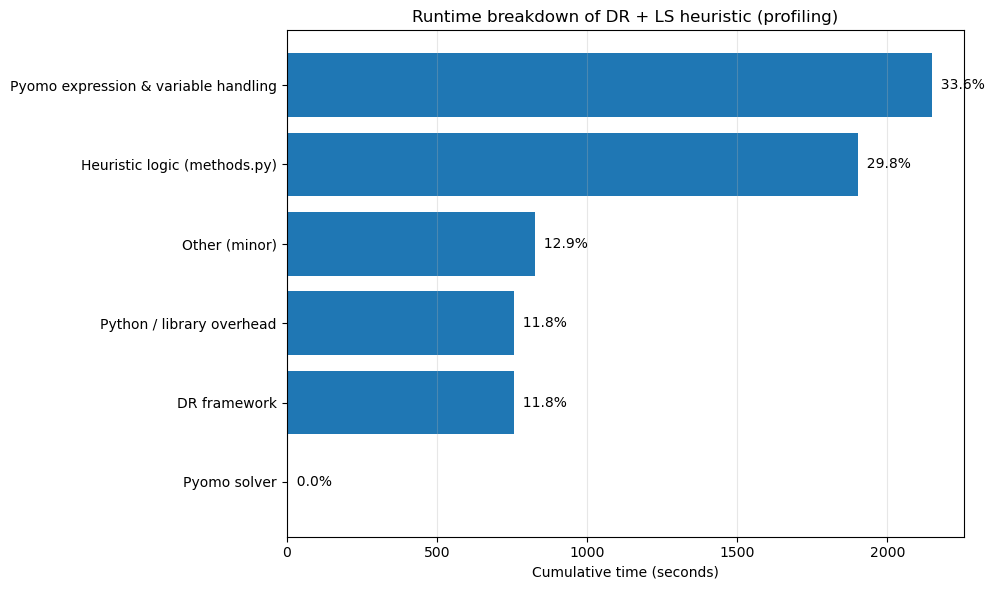

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.barh(summary["category"], summary["cumtime"])
plt.gca().invert_yaxis()

plt.xlabel("Cumulative time (seconds)")
plt.title("Runtime breakdown of DR + LS heuristic (profiling)")
plt.grid(axis="x", alpha=0.3)

for i in range(len(summary)):
    t = summary.loc[i, "cumtime"]
    p = summary.loc[i, "percent"]
    plt.text(t, i, f"  {p:.1f}%", va="center")

plt.tight_layout()
plt.show()
